## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from pycaret.datasets import get_data
from pycaret.classification import *
import matplotlib.pyplot as plt
import os

## Define functions

In [2]:
dataset_prefix = '0_01-partial-dataset'

In [3]:
def save_pre_processed_dataset(df: pd.DataFrame, name):
    """Save as the dataset pre-processed as csv in the dir root/Datasets/CSE-CIC/IDS2018/pre-processed/"""
    file_name = dataset_prefix + '-' + name + '.csv'
    
    # Define the path to save the dataset pre-processed
    file_path = os.path.join(os.getcwd(), '..', 'Datasets', 'CSE-CIC-IDS2018', 'pre-processed', file_name)

    # Save the dataset pre-processed
    df.to_csv(file_path ,index=False)

In [4]:
def test_and_save_pre_processing_approach(approach_name, setup):
    # Test different algorithms
    setup.compare_models(include = ['ada', 'gbc', 'et','xgboost', 'rf', 'dt', 'lightgbm'])
    # setup.compare_models()
    
    # Getting the resulting df of the models_comparison
    df_models_comparison = pull().copy()
    
    # Getting the dataset_pre_processed by the autoML
    df_dataset_pre_processed = setup.get_config('dataset_transformed').copy()

    # Save as the dataset pre-processed as csv in the dir root/Datasets/CSE-CIC/IDS2018/pre-processed/
    save_pre_processed_dataset(df_dataset_pre_processed, approach_name)

    return df_models_comparison, df_dataset_pre_processed


In [5]:
colors_list = [
        '#1982C4',  # Azul
        '#B4436C',  # Roxo
        '#F2C14E', # Amarelo
        '#ED217C', # Rosa
        '#5FAD56', # Verde
        '#F78154', # Laranja
        '#4D9078', # Azul esverdeado
        ]

def plot_radar_curves(subplot, column, dfs_dict, angles):
    for index, (name, df) in enumerate(dfs_dict.items()):
        values = df[column].tolist()
        values += values[:1]
        subplot.plot(angles, values, color=colors_list[index], linewidth=2, linestyle='solid', label=name)
        subplot.fill(angles, values, color=colors_list[index], alpha=0.25)

def compare_metrics(dfs_dict, chart_name):

    # Cria colunas com a sigla dos modelos
    for name, df in dfs_dict.items():
        df = df.reset_index()
        df = df.rename(columns={'index': 'Model Alias'})
        dfs_dict[name] = df

    # Número de variáveis
    labels = dfs_dict[list(dfs_dict.keys())[0]]['Model Alias']
    num_vars = len(labels)

    # Ângulos dos eixos
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Completa o círculo

    # Criação dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))

    # Gráfico 1
    # ATENÇÃO
    # Escrever um for para plotar o gráfico para cada datafra
    
    # Plotar Recall
    plot_radar_curves(ax1, 'Recall', dfs_dict, angles)
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(labels, fontsize=14)
    ax1.set_title('Revocação', fontsize=25)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Plotar F1 Score
    plot_radar_curves(ax2, 'F1', dfs_dict, angles)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(labels, fontsize=14)
    ax2.set_title('Medida-F1', fontsize=25)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Ajustar o layout
    plt.tight_layout()

    # Salvar a imagem
    file_path = os.path.join('imgs', f'{chart_name}.png')
    plt.savefig(file_path, dpi=300)

    # Mostrar o gráfico
    plt.show()

## Set display unlimited number of lines

In [6]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Load datasets in pandas dataframes

In [7]:
# Define the path to the folder containing the CSV files
file_path = os.path.join(os.getcwd(), '..', 'Datasets', 'CSE-CIC-IDS2018', 'raw', '0_01-partial-dataset.csv')
# Import csv to pandas
dataset = pd.read_csv(file_path)

# Pre-processing

## 1. First steps for pycaret be able to consume

#### Replace -inf/+inf for Nan

In [8]:
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

#### Convert Timestamp values to pandas date and time datetime64 format

In [9]:
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

## 2. Pre-processing using Pycaret

### 2.1 Generic pre-processing specifications techniques
The autoML choose the following parameters automatically:
- inputation_type: simple
    - numeric_imputation: mean
    - categorical_imputation: mode
- fold_strategy: stratifiedkfold
    - fold: 10

In [112]:
generic_pre_processing_setup = setup(
                                dataset, 
                                target = 'Label',
                                imputation_type = 'simple',
                                numeric_imputation = 'mean',
                                categorical_imputation = 'mode',
                                fold_strategy = 'stratifiedkfold',
                                fold = 10
                                )

In [113]:
result = test_and_save_pre_processing_approach('generic_pre_processing', generic_pre_processing_setup)
models_comparison_generic = result[0]
dataset_generic_pre_processing = result[1]

Initiated  . . . . . . . . . . . . . . . . . .                      20:14:51
Status     . . . . . . . . . . . . . . . . . .              Fitting 10 Folds
Estimator  . . . . . . . . . . . . . . . . . .  Gradient Boosting Classifier

Processing:   0%|          | 0/33 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 2.2 Specifyng date feature pre-processing
- Discarding year
- Adding second, day and month features

This discarding is necessary beacause the year of the network package must not be taken as a variable to determine if the package is malicious or not

In [37]:
date_specific_pre_processing_setup = setup(
                                    dataset, 
                                    target = 'Label',
                                    date_features = ['Timestamp'],
                                    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                    imputation_type = 'simple',
                                    numeric_imputation = 'mean',
                                    categorical_imputation = 'mode',
                                    fold_strategy = 'stratifiedkfold',
                                    fold = 10
                                )

In [38]:
result = test_and_save_pre_processing_approach('date_specific_pre_processing', date_specific_pre_processing_setup)
models_comparison_date_specific = result[0]
dataset_date_specific_pre_processing = result[1]

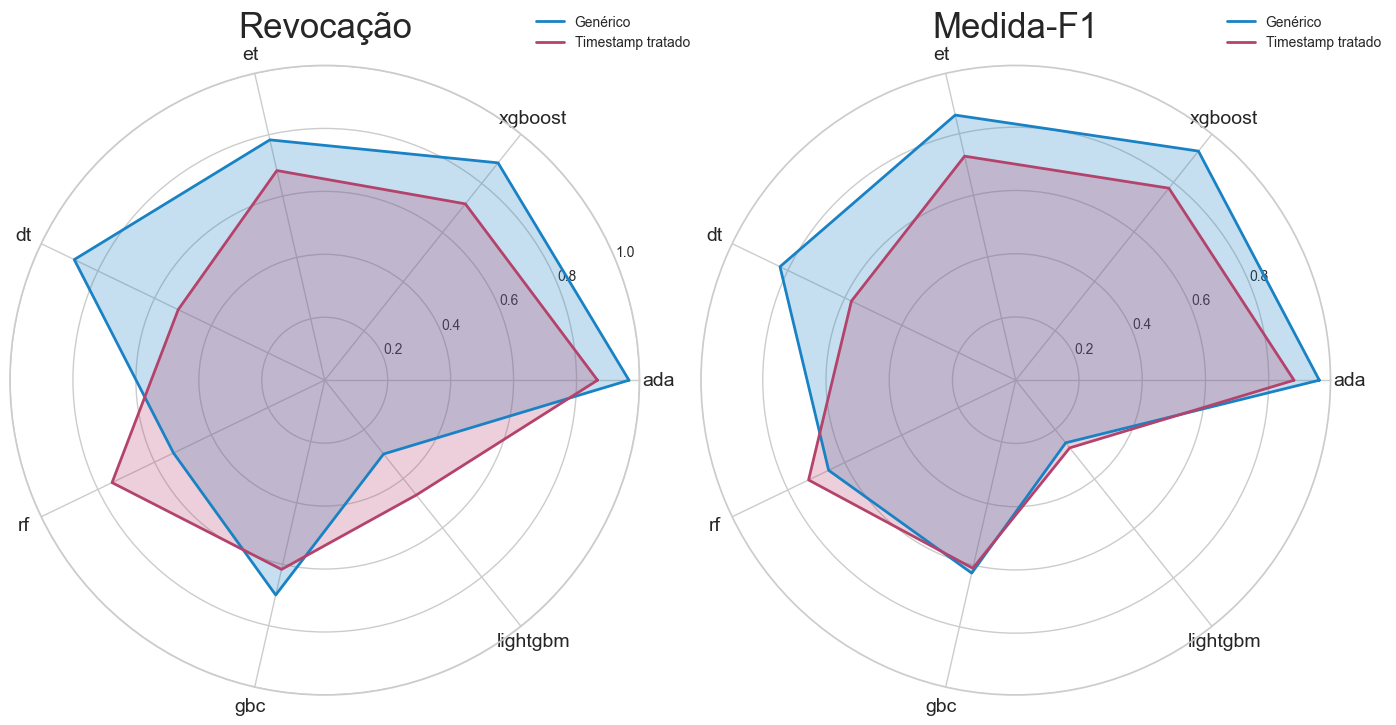

In [39]:
generic_X_date_specific = {
    "Genérico": models_comparison_generic,
    "Timestamp tratado": models_comparison_date_specific
}


compare_metrics(generic_X_date_specific, 'generic_X_date_specific')

### 2.3 Missing values pre-processing

In [40]:
simple_imputation_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'knn',
                                                categorical_imputation = 'mode',
                                                fold = 10
                                                )

In [41]:
result = test_and_save_pre_processing_approach('simple_imputation_pre_processing', simple_imputation_pre_processing_setup)
models_comparison_simple_imputation = result[0]
dataset_simple_imputation_pre_processing = result[1]

In [42]:
simple_imputation_2_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'mean',
                                                categorical_imputation = 'mode',
                                                fold = 10
                                                )

In [43]:
result = test_and_save_pre_processing_approach('simple_imputation_2_pre_processing', simple_imputation_2_pre_processing_setup)
models_comparison_simple_imputation_2 = result[0]
dataset_simple_imputation_2_pre_processing = result[1]

In [44]:
simple_imputation_3_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'median',
                                                categorical_imputation = 'mode',
                                                fold = 10
                                                )


result = test_and_save_pre_processing_approach('simple_imputation_3_pre_processing', simple_imputation_3_pre_processing_setup)
models_comparison_simple_imputation_3 = result[0]
dataset_simple_imputation_3_pre_processing = result[1]

In [45]:
simple_imputation_4_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'drop',
                                                categorical_imputation = 'mode',
                                                fold = 10
                                                )


result = test_and_save_pre_processing_approach('simple_imputation_4_pre_processing', simple_imputation_4_pre_processing_setup)
models_comparison_simple_imputation_4 = result[0]
dataset_simple_imputation_4_pre_processing = result[1]

In [46]:
simple_imputation_5_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'mode',
                                                categorical_imputation = 'mode',
                                                fold = 10
                                                )


result = test_and_save_pre_processing_approach('simple_imputation_5_pre_processing', simple_imputation_5_pre_processing_setup)
models_comparison_simple_imputation_5 = result[0]
dataset_simple_imputation_5_pre_processing = result[1]

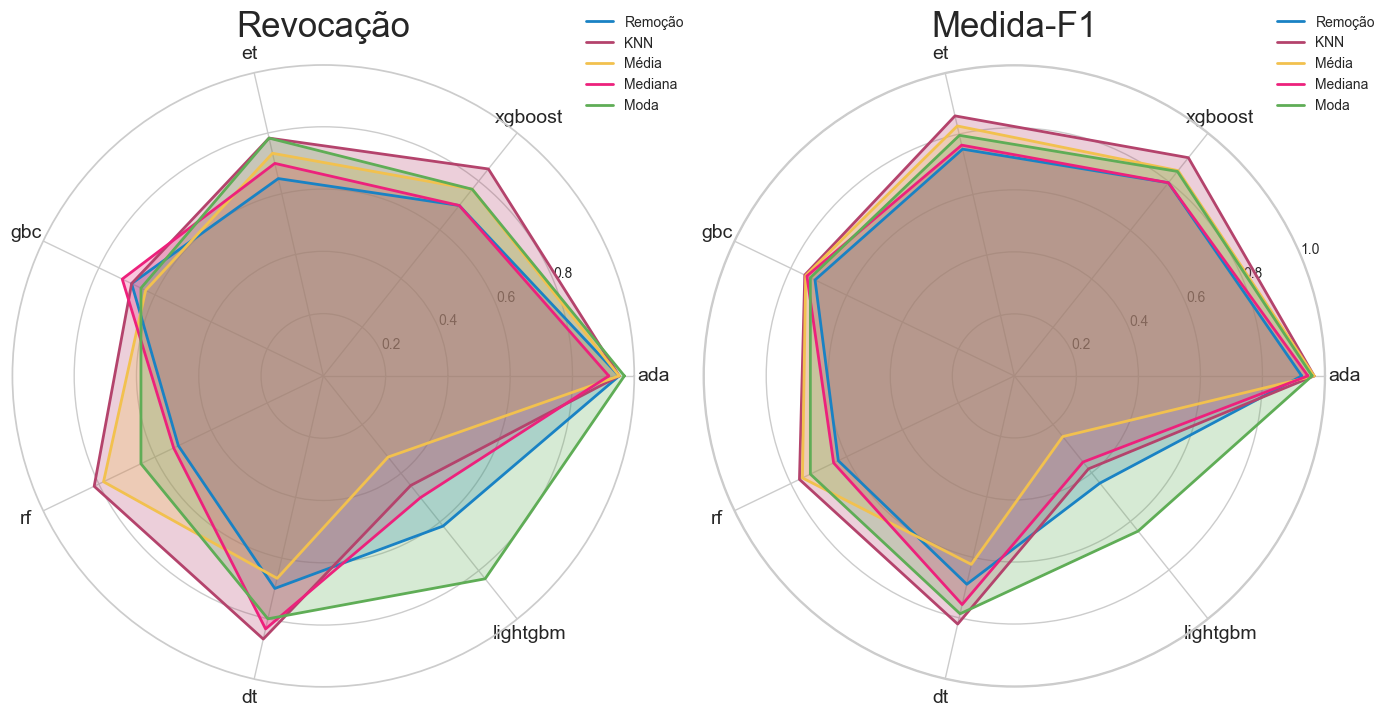

In [47]:
KNN_X_Mean = {
    "Remoção": models_comparison_simple_imputation_4,
    "KNN": models_comparison_simple_imputation,
    "Média": models_comparison_simple_imputation_2,
    "Mediana": models_comparison_simple_imputation_3,
    "Moda": models_comparison_simple_imputation_5,
}


compare_metrics(KNN_X_Mean, 'missign_values_types')

In [48]:
iterative_imputation_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'iterative',
                                                numeric_iterative_imputer = 'lightgbm',
                                                fold_strategy = 'stratifiedkfold',
                                                fold = 10
                                                )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12915
[LightGBM] [Info] Number of data points in the train set: 21937, number of used features: 70
[LightGBM] [Info] Start training from score 304821.383761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12915
[LightGBM] [Info] Number of data points in the train set: 21937, number of used features: 70
[LightGBM] [Info] Start training from score 28252.710549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

In [49]:
result = test_and_save_pre_processing_approach('iterative_imputation_pre_processing', iterative_imputation_pre_processing_setup)
models_comparison_iterative_imputation = result[0]
dataset_iterative_imputation_pre_processing = result[1]

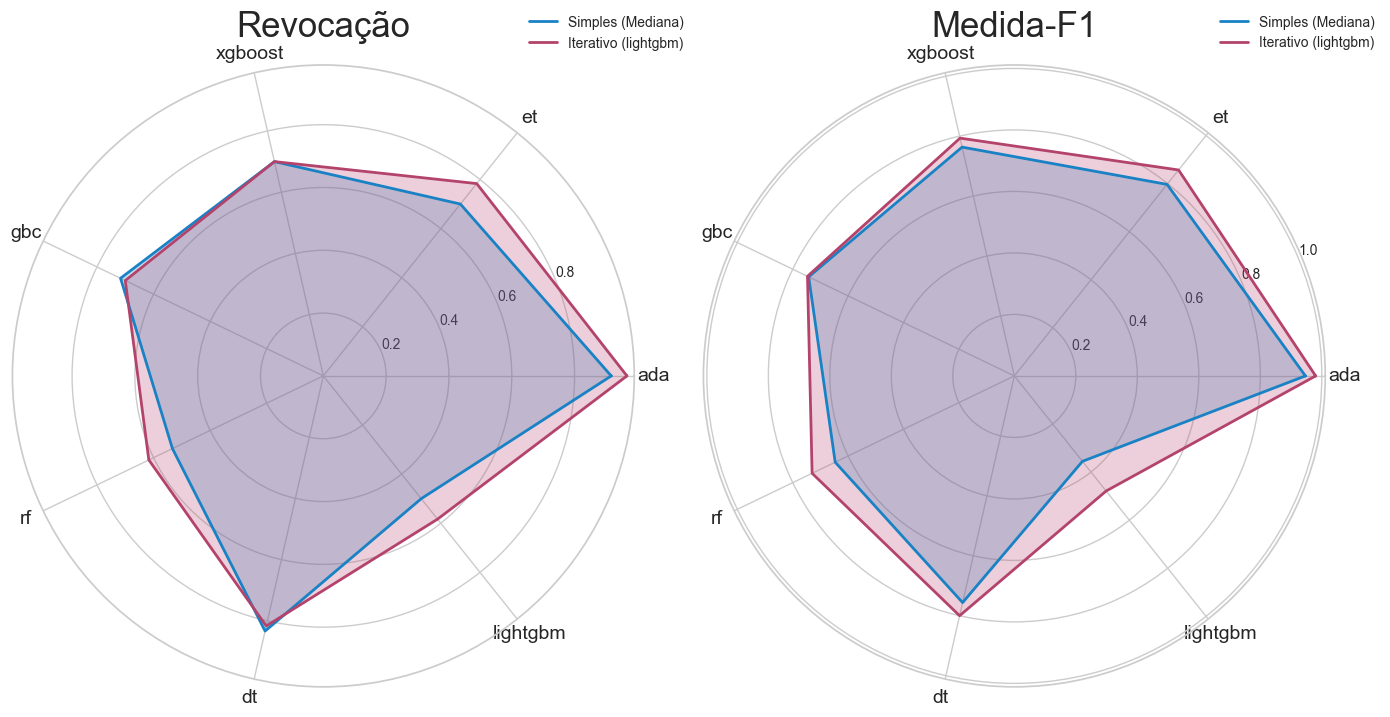

In [101]:
Simples_X_Iterativo = {
    "Simples (Mediana)": models_comparison_simple_imputation_3,
    "Iterativo (lightgbm)": models_comparison_iterative_imputation
}


compare_metrics(Simples_X_Iterativo, 'missing_values')

#### Conclusion
Analyzing mainly the Recall and F1 metrics it was possible do see:
- The Decision Tree and Extra Trees algorithms were improved
- The Ada Boost and Extreme Gradiend Boosting were deteriorated

### 2.4 Fix imbalance pre-processing

In [55]:
fix_imbalance_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'mean',
                                                categorical_imputation = 'mode',
                                                fold_strategy = 'stratifiedkfold',
                                                fold = 10,
                                                fix_imbalance = True,
                                                fix_imbalance_method = 'SMOTE'
                                                )

In [56]:
result = test_and_save_pre_processing_approach('fix_imbalance_pre_processing', fix_imbalance_pre_processing_setup)
models_comparison_fix_imbalance = result[0]
dataset_fix_imbalance_pre_processing = result[1]

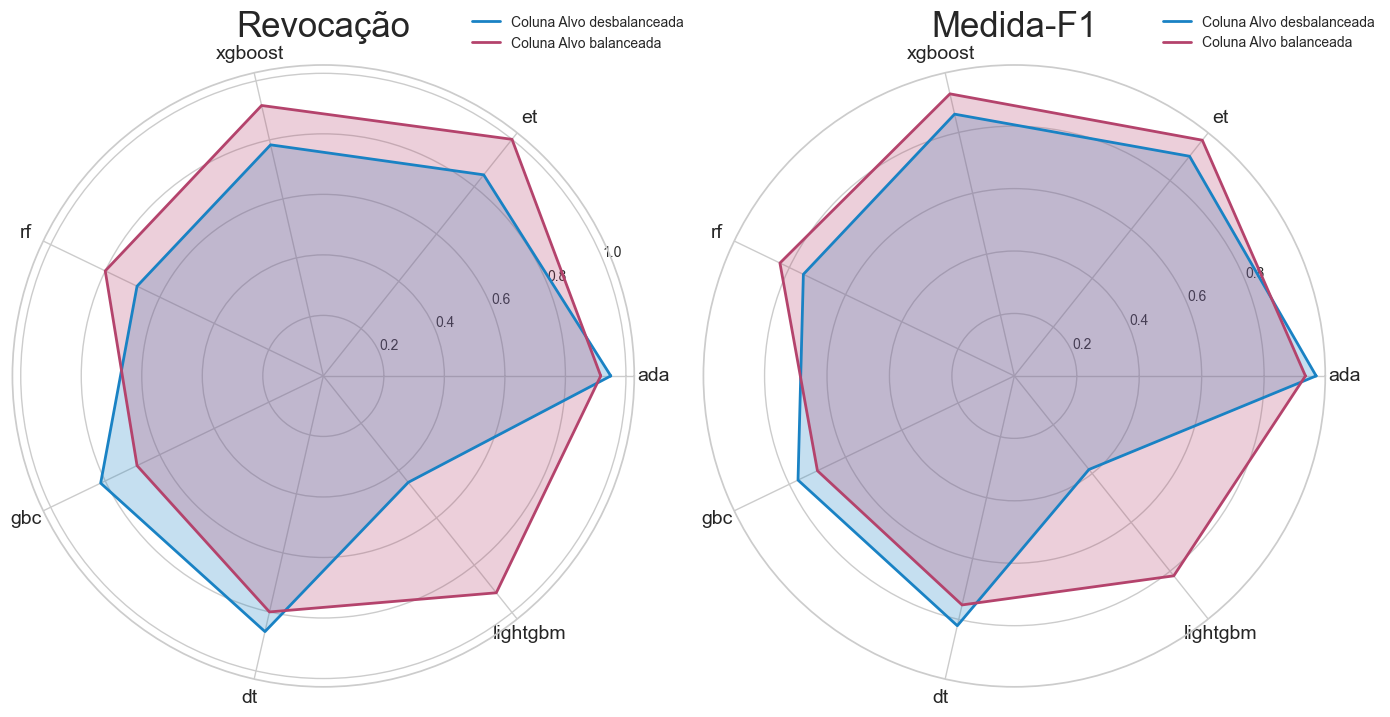

In [99]:
Fix_Imbalance = {
    "Coluna Alvo desbalanceada": models_comparison_simple_imputation,
    "Coluna Alvo balanceada": models_comparison_fix_imbalance,
}


compare_metrics(Fix_Imbalance, 'fix_imbalance')

#### Conclusion
Analyzing mainly the Recall and F1 metrics it was possible do see:
- The SMOTE method proved be the most suitable
- The Ada, xgboost, gbc and rf were improved
- The Decision Tree were deteriorated

### 2.5 Remove Outliers pre-processing

In [58]:
remove_outliers_pre_processing_setup = setup(
                                            dataset, 
                                            target = 'Label',
                                            date_features = ['Timestamp'],
                                            create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                            imputation_type = 'simple',
                                            numeric_imputation = 'mean',
                                            categorical_imputation = 'mode',
                                            fold_strategy = 'stratifiedkfold',
                                            fold = 10,
                                            fix_imbalance = True,
                                            fix_imbalance_method = 'SMOTE',
                                            remove_outliers = True,
                                            outliers_method = 'iforest'
                                            )

In [59]:
result = test_and_save_pre_processing_approach('remove_outliers_pre_processing', remove_outliers_pre_processing_setup)
models_comparison_remove_outliers = result[0]
dataset_remove_outliers_pre_processing = result[1]

In [60]:
remove_outliers_2_pre_processing_setup = setup(
                                            dataset, 
                                            target = 'Label',
                                            date_features = ['Timestamp'],
                                            create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                            imputation_type = 'simple',
                                            numeric_imputation = 'mean',
                                            categorical_imputation = 'mode',
                                            fold_strategy = 'stratifiedkfold',
                                            fold = 10,
                                            fix_imbalance = True,
                                            fix_imbalance_method = 'SMOTE',
                                            remove_outliers = True,
                                            outliers_method = 'ee'
                                            )

In [61]:
result = test_and_save_pre_processing_approach('remove_outliers_2_pre_processing', remove_outliers_2_pre_processing_setup)
models_comparison_remove_outliers_2 = result[0]
dataset_remove_outliers_2_pre_processing = result[1]

In [62]:
remove_outliers_3_pre_processing_setup = setup(
                                            dataset, 
                                            target = 'Label',
                                            date_features = ['Timestamp'],
                                            create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                            imputation_type = 'simple',
                                            numeric_imputation = 'mean',
                                            categorical_imputation = 'mode',
                                            fold_strategy = 'stratifiedkfold',
                                            fold = 10,
                                            fix_imbalance = True,
                                            fix_imbalance_method = 'SMOTE',
                                            remove_outliers = True,
                                            outliers_method = 'lof'
                                            )

In [63]:
result = test_and_save_pre_processing_approach('remove_outliers_3_pre_processing', remove_outliers_3_pre_processing_setup)
models_comparison_remove_outliers_3 = result[0]
dataset_remove_outliers_3_pre_processing = result[1]

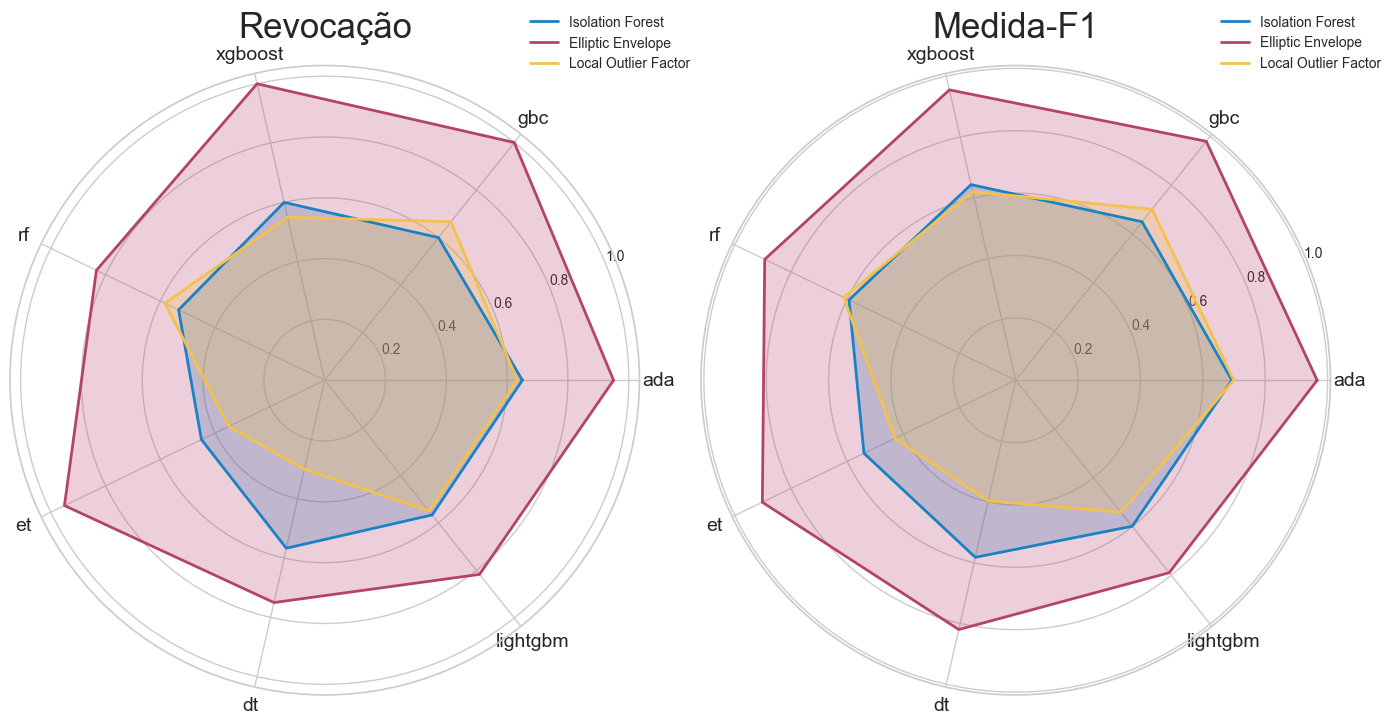

In [64]:
Remove_Outliers_Types = {
    # "Caso anterior": models_comparison_fix_imbalance,
    "Isolation Forest": models_comparison_remove_outliers,
    "Elliptic Envelope": models_comparison_remove_outliers_2,
    "Local Outlier Factor": models_comparison_remove_outliers_3
}


compare_metrics(Remove_Outliers_Types, 'remove_outliers_types')

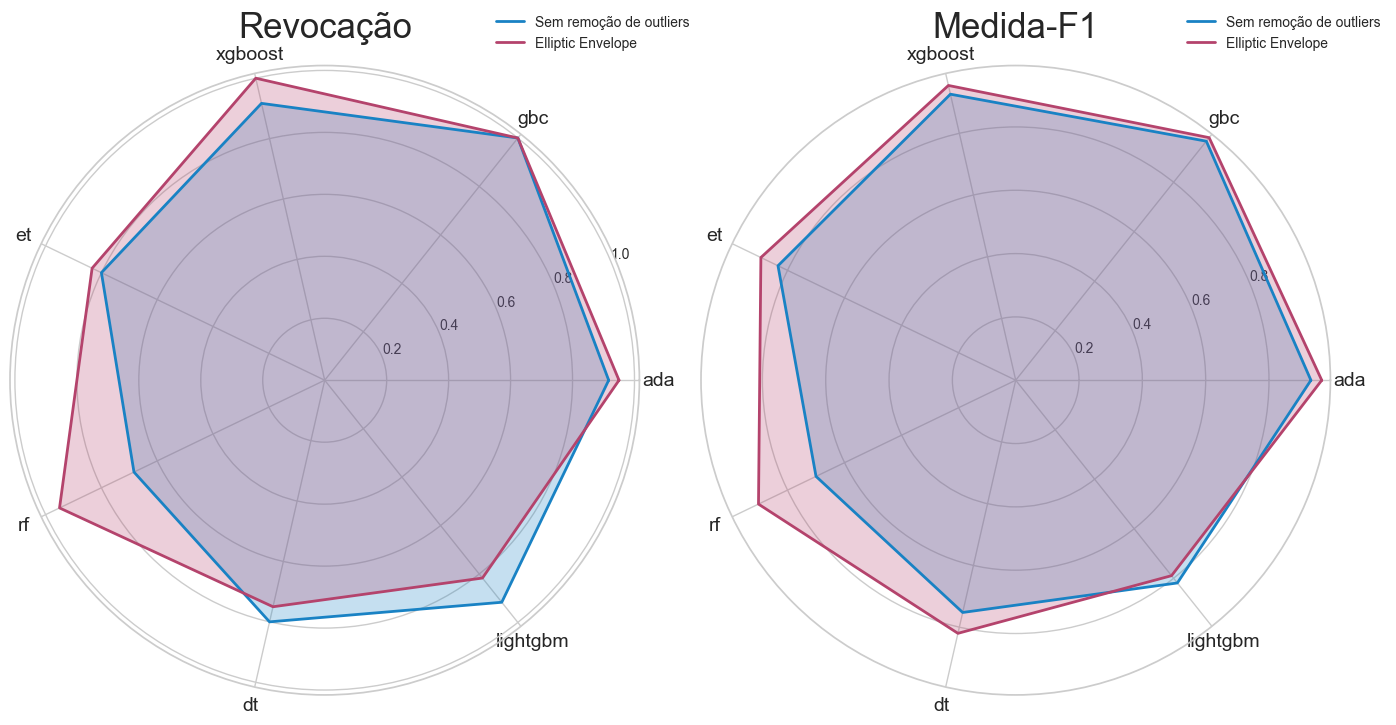

In [98]:
Remove_Outliers = {
    "Sem remoção de outliers": models_comparison_fix_imbalance,
    "Elliptic Envelope": models_comparison_remove_outliers_2
}


compare_metrics(Remove_Outliers, 'remove_outliers')

#### Conclusion
Analyzing mainly the Recall and F1 metrics it was possible do see:
- The ee method proved be the most suitable
- The only algortihm that has been improved was the Extra trees
- All the others algorithms has been deteriorated

So we wil not use remove_outliers method

### 2.6 Normalize pre-processing

In [66]:
normalize_pre_processing_setup = setup(
                                    dataset, 
                                    target = 'Label',
                                    date_features = ['Timestamp'],
                                    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                    imputation_type = 'simple',
                                    numeric_imputation = 'mean',
                                    categorical_imputation = 'mode',
                                    fold_strategy = 'stratifiedkfold',
                                    fold = 10,
                                    fix_imbalance = True,
                                    fix_imbalance_method = 'SMOTE',
                                    normalize = True,
                                    # Test different zscore
                                    normalize_method = 'zscore'
                                    )

In [67]:
result = test_and_save_pre_processing_approach('normalize_pre_processing', normalize_pre_processing_setup)
models_comparison_normalize = result[0]
dataset_normalize_pre_processing = result[1]

In [12]:
normalize_2_pre_processing_setup = setup(
                                    dataset, 
                                    target = 'Label',
                                    date_features = ['Timestamp'],
                                    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                    imputation_type = 'simple',
                                    numeric_imputation = 'mean',
                                    categorical_imputation = 'mode',
                                    fold_strategy = 'stratifiedkfold',
                                    fold = 10,
                                    fix_imbalance = True,
                                    fix_imbalance_method = 'SMOTE',
                                    normalize = True,
                                    # Test different zscore
                                    normalize_method = 'minmax'
                                    )

In [13]:
result = test_and_save_pre_processing_approach('normalize_2_pre_processing', normalize_2_pre_processing_setup)
models_comparison_normalize_2 = result[0]
dataset_normalize_2_pre_processing = result[1]

In [70]:
normalize_3_pre_processing_setup = setup(
                                    dataset, 
                                    target = 'Label',
                                    date_features = ['Timestamp'],
                                    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                    imputation_type = 'simple',
                                    numeric_imputation = 'mean',
                                    categorical_imputation = 'mode',
                                    fold_strategy = 'stratifiedkfold',
                                    fold = 10,
                                    fix_imbalance = True,
                                    fix_imbalance_method = 'SMOTE',
                                    normalize = True,
                                    normalize_method = 'maxabs'
                                    )

In [71]:
result = test_and_save_pre_processing_approach('normalize_3_pre_processing', normalize_3_pre_processing_setup)
models_comparison_normalize_3 = result[0]
dataset_normalize_3_pre_processing = result[1]











In [72]:
normalize_4_pre_processing_setup = setup(
                                    dataset, 
                                    target = 'Label',
                                    date_features = ['Timestamp'],
                                    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                    imputation_type = 'simple',
                                    numeric_imputation = 'mean',
                                    categorical_imputation = 'mode',
                                    fold_strategy = 'stratifiedkfold',
                                    fold = 10,
                                    fix_imbalance = True,
                                    fix_imbalance_method = 'SMOTE',
                                    normalize = True,
                                    # Test different zscore
                                    normalize_method = 'robust'
                                    )

In [73]:
result = test_and_save_pre_processing_approach('normalize_4_pre_processing', normalize_4_pre_processing_setup)
models_comparison_normalize_4 = result[0]
dataset_normalize_4_pre_processing = result[1]

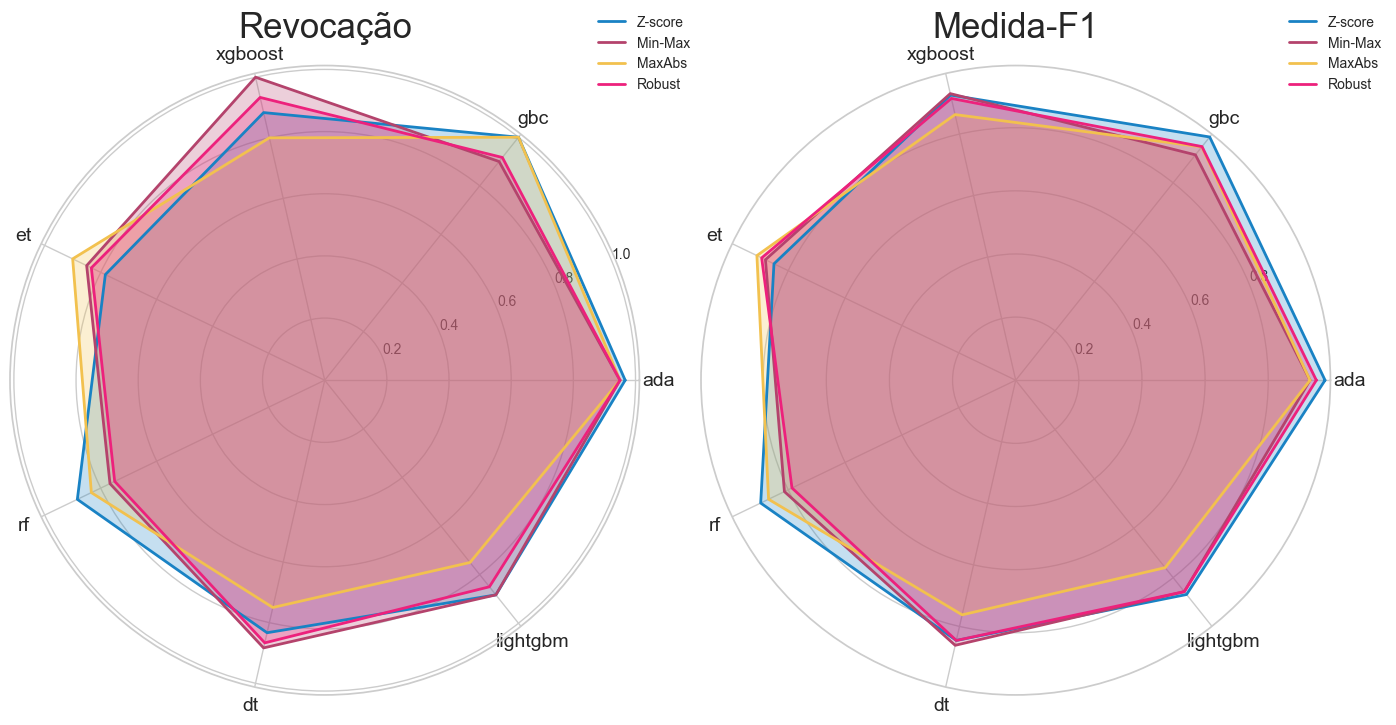

In [74]:
Normalize_Types = {
    "Z-score": models_comparison_normalize,
    "Min-Max": models_comparison_normalize_2,
    "MaxAbs": models_comparison_normalize_3,
    "Robust": models_comparison_normalize_4
}


compare_metrics(Normalize_Types, 'normalize_types')

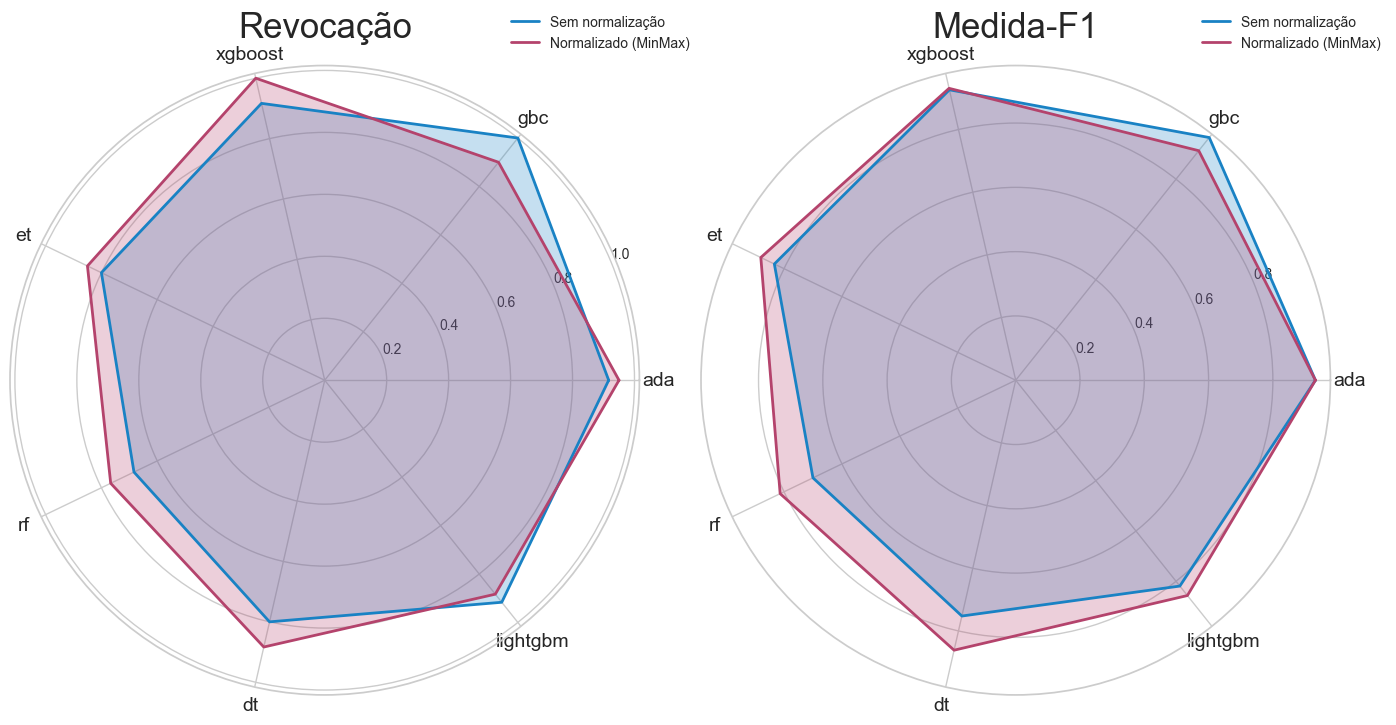

In [100]:
Normalize = {
    "Sem normalização": models_comparison_fix_imbalance,
    "Normalizado (MinMax)": models_comparison_normalize_2,
}


compare_metrics(Normalize, 'normalize')

#### Conclusion

Analyzing mainly the Recall and F1 Score it was possible to see:

- The maxabs was the most suitable normalize method
- This normalization generally improved the Recall and F1 Score of the main algorithms
- The only exceptions were the F1 Score of the ada and gbc algorithms, that slightly decreased 

So this method could be a good choice for pre-processing


### 2.7 Feature Transform pre-processing

In [14]:
transformation_feature_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'mean',
                                                categorical_imputation = 'mode',
                                                fold_strategy = 'stratifiedkfold',
                                                fold = 10,
                                                fix_imbalance = True,
                                                fix_imbalance_method = 'SMOTE',
                                                transformation = True,
                                                transformation_method = 'yeo-johnson'
                                                )

In [15]:
result = test_and_save_pre_processing_approach('transformation_feature_pre_processing', transformation_feature_pre_processing_setup)
models_comparison_transformation_feature = result[0]
dataset_transformation_feature_pre_processing = result[1]

In [78]:
transformation_feature_2_pre_processing_setup = setup(
                                                dataset, 
                                                target = 'Label',
                                                date_features = ['Timestamp'],
                                                create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                                imputation_type = 'simple',
                                                numeric_imputation = 'mean',
                                                categorical_imputation = 'mode',
                                                fold_strategy = 'stratifiedkfold',
                                                fold = 10,
                                                fix_imbalance = True,
                                                fix_imbalance_method = 'SMOTE',
                                                transformation = True,
                                                transformation_method = 'quantile'
                                                )

In [79]:
result = test_and_save_pre_processing_approach('transformation_feature_2_pre_processing', transformation_feature_2_pre_processing_setup)
models_comparison_transformation_feature_2 = result[0]
dataset_transformation_feature_2_pre_processing = result[1]

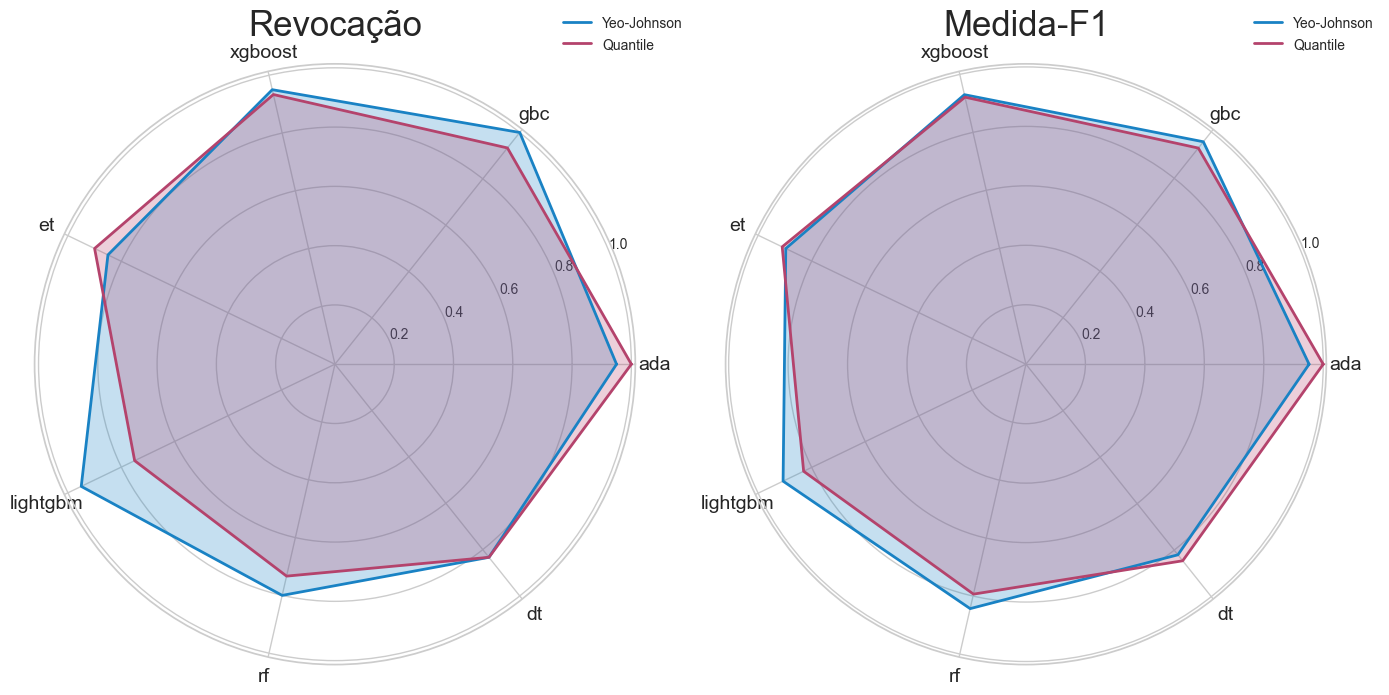

In [80]:
Yeo_X_Quantile = {
    "Yeo-Johnson": models_comparison_transformation_feature,
    "Quantile": models_comparison_transformation_feature_2,
}


compare_metrics(Yeo_X_Quantile, 'yeo_x_quantile')

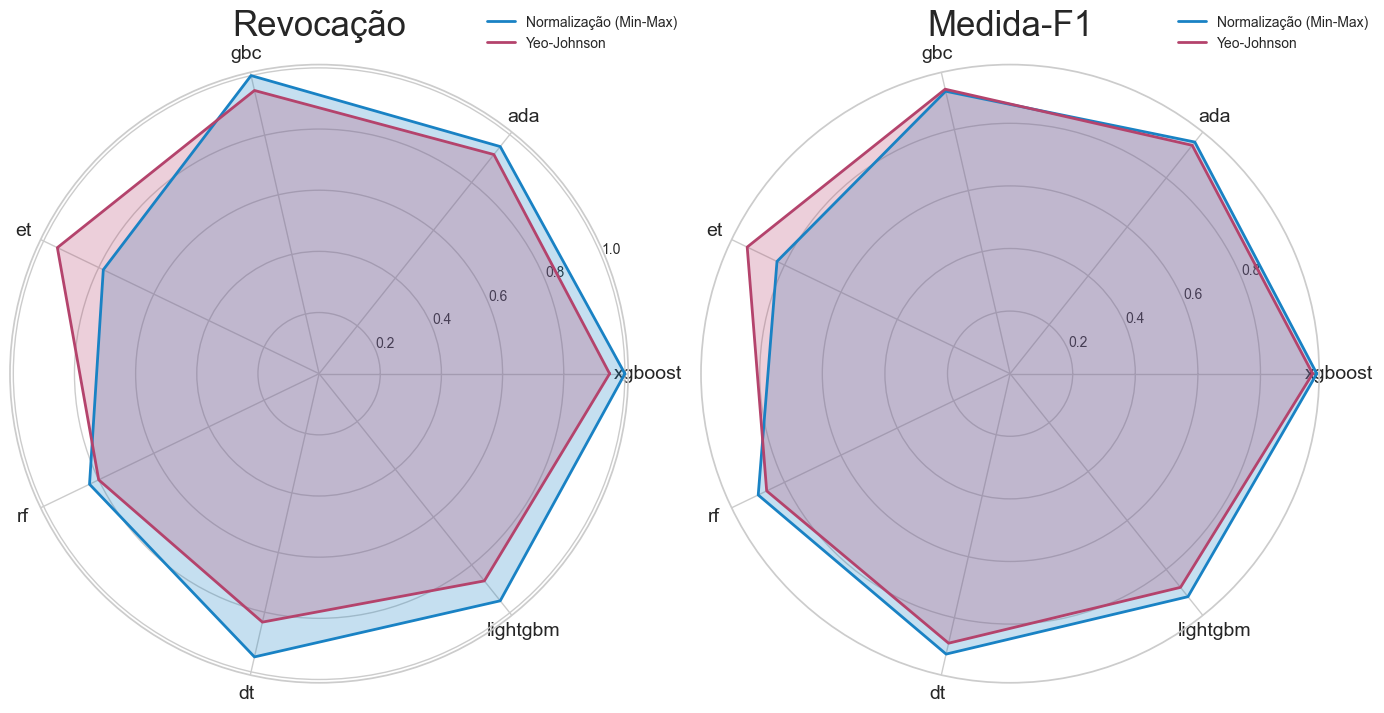

In [16]:
Transformation_Feature_X_Normalize = {
    "Normalização (Min-Max)": models_comparison_normalize_2,
    "Yeo-Johnson": models_comparison_transformation_feature,
    # "Nenhum": models_comparison_fix_imbalance
}


compare_metrics(Transformation_Feature_X_Normalize, 'transformation_feature_X_normalize')

#### Conclusion

Analyzing mainly the Recall and F1 Score it was possible to see:

- This method brign only deterioration to the mainly algortithms that we are considering

So we will not use the Transformation feature method

fold_pre_processing_setup = setup(
    dataset, 
    target = 'Label',
    date_features = ['Timestamp'],
    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
    imputation_type = 'simple',
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    fold_strategy = 'stratifiedkfold',
    fold = 10,
    fix_imbalance = True,
    fix_imbalance_method = 'SMOTE',
    
    )

### 2.8 Feature Selection

In [10]:
control_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        
                                        )


In [11]:
result = test_and_save_pre_processing_approach('control_pre_processing', control_pre_processing_setup)
models_comparison_control = result[0]
dataset_control_pre_processing = result[1]

In [13]:
univariate_feature_selection_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        feature_selection = True,
                                        feature_selection_method = 'univariate'
                                        )

result = test_and_save_pre_processing_approach('univariate_feature_selection_pre_processing', univariate_feature_selection_pre_processing_setup)
models_comparison_univariate_feature_selection = result[0]
dataset_univariate_feature_selection_pre_processing = result[1]

In [14]:
classic_feature_selection_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        feature_selection = True,
                                        feature_selection_method = 'classic'
                                        )

result = test_and_save_pre_processing_approach('classic_feature_selection_pre_processing', classic_feature_selection_pre_processing_setup)
models_comparison_classic_feature_selection = result[0]
dataset_classic_feature_selection_pre_processing = result[1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 22012, number of negative: 22012
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15487
[LightGBM] [Info] Number of data points in the train set: 44024, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [15]:
sequential_feature_selection_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        feature_selection = True,
                                        feature_selection_method = 'sequential'
                                        )

result = test_and_save_pre_processing_approach('sequential_feature_selection_pre_processing', sequential_feature_selection_pre_processing_setup)
models_comparison_sequential_feature_selection = result[0]
dataset_sequential_feature_selection_pre_processing = result[1]

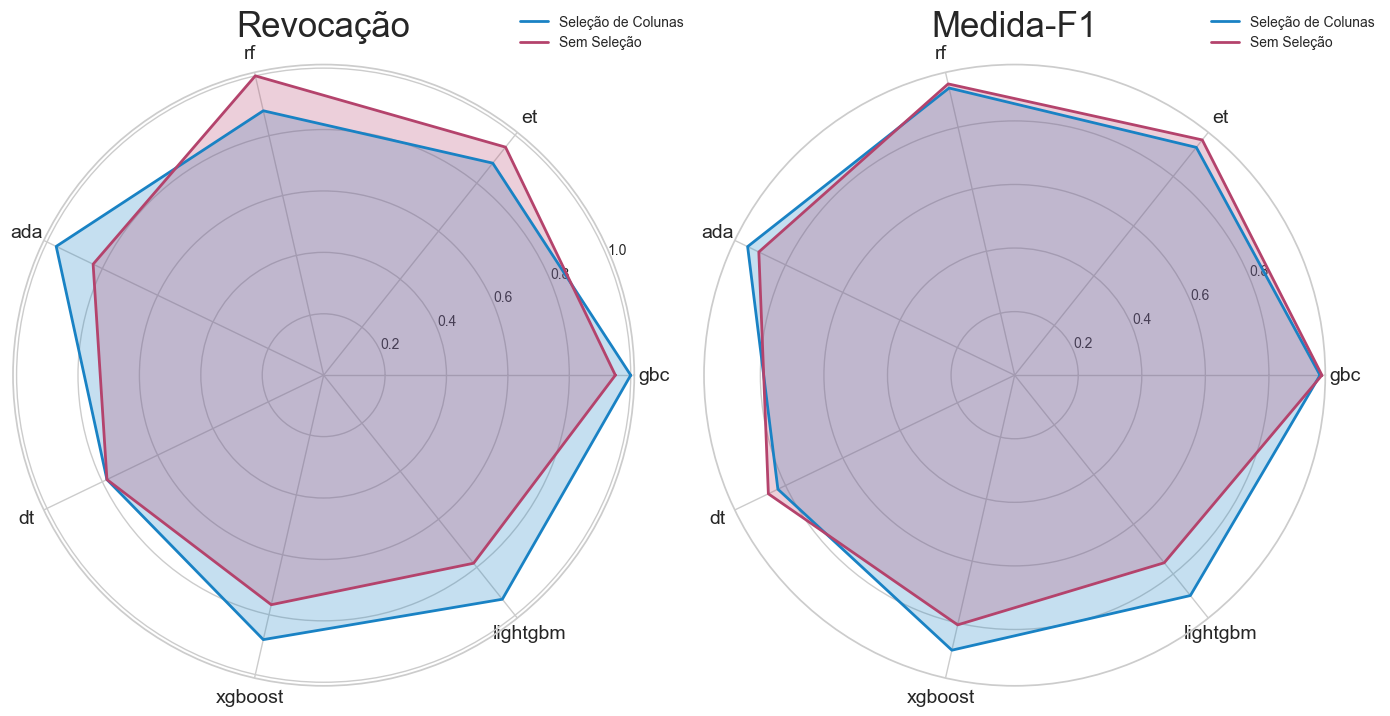

In [25]:

Feature_Selection = {
    "Seleção de Colunas": models_comparison_classic_feature_selection,
    # "Univariável": models_comparison_univariate_feature_selection,
    "Sem Seleção": models_comparison_control
}


compare_metrics(Feature_Selection, 'Feature_Selection')

### 2.9 Remoção de colinearidade

In [26]:
remove_multicollinearity_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        remove_multicollinearity = True
                                        )

result = test_and_save_pre_processing_approach('remove_multicollinearity_pre_processing', remove_multicollinearity_pre_processing_setup)
models_comparison_remove_multicollinearity = result[0]
dataset_remove_multicollinearity_pre_processing = result[1]

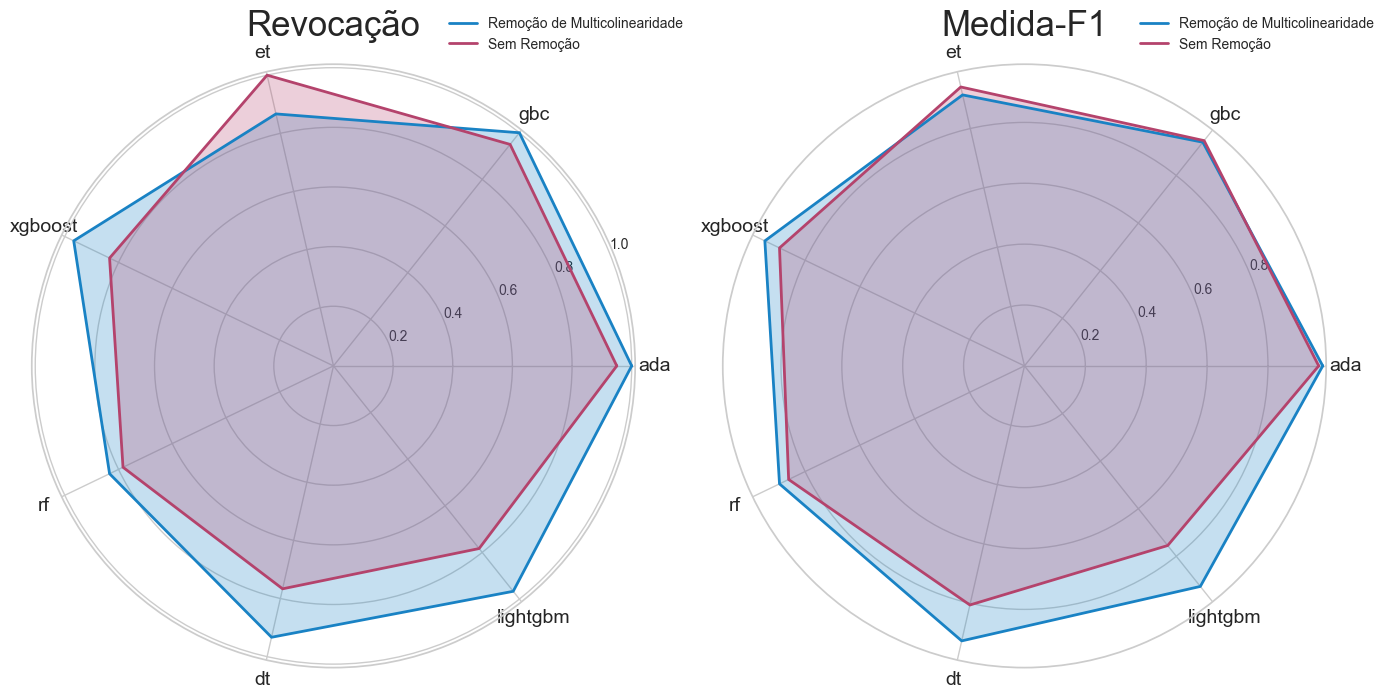

In [27]:
Remove_Multicollinearity = {
    "Remoção de Multicolinearidade": models_comparison_remove_multicollinearity,
    "Sem Remoção": models_comparison_control,
}


compare_metrics(Remove_Multicollinearity, 'Remove_Multicollinearity')

### 2.11 PCA

In [37]:
linear_pca_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        pca = True,
                                        pca_method = 'linear',
                                        pca_components = 70
                                        )

result = test_and_save_pre_processing_approach('linear_pca_pre_processing', linear_pca_pre_processing_setup)
models_comparison_linear_pca = result[0]
dataset_linear_pca_pre_processing = result[1]

In [36]:
kernel_pca_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        pca = True,
                                        pca_method = 'kernel',
                                        pca_components = 70
                                        )

result = test_and_save_pre_processing_approach('kernel_pca_pre_processing', kernel_pca_pre_processing_setup)
models_comparison_kernel_pca = result[0]
dataset_kernel_pca_pre_processing = result[1]

KeyboardInterrupt: 

In [35]:
len(dataset_control_pre_processing.columns)

84

In [38]:
incremental_pca_pre_processing_setup = setup(
                                        dataset, 
                                        target = 'Label',
                                        date_features = ['Timestamp'],
                                        create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
                                        imputation_type = 'simple',
                                        numeric_imputation = 'mean',
                                        categorical_imputation = 'mode',
                                        fold_strategy = 'stratifiedkfold',
                                        fold = 10,
                                        fix_imbalance = True,
                                        fix_imbalance_method = 'SMOTE',
                                        transformation = True,
                                        transformation_method = 'yeo-johnson',
                                        pca = True,
                                        pca_method = 'incremental',
                                        pca_components = 70
                                        )

result = test_and_save_pre_processing_approach('incremental_pca_pre_processing', incremental_pca_pre_processing_setup)
models_comparison_incremental_pca = result[0]
dataset_incremental_pca_pre_processing = result[1]

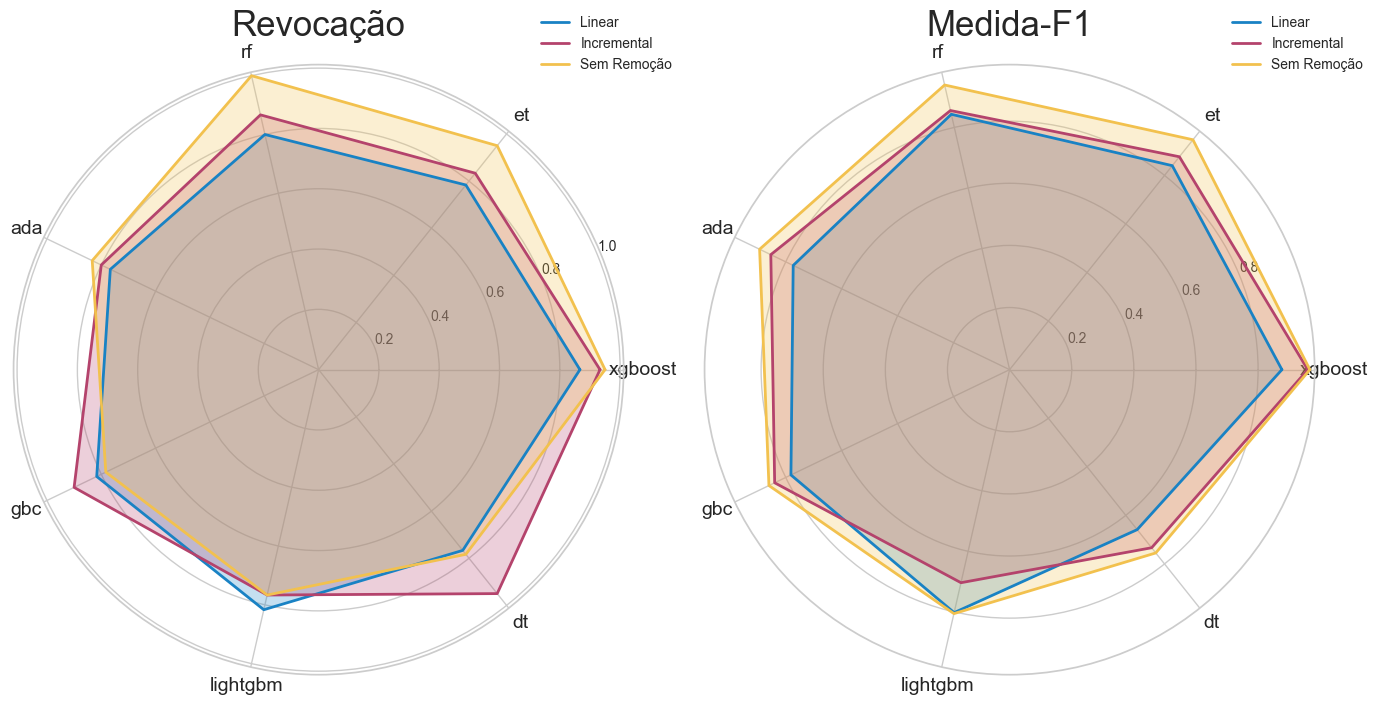

In [39]:
PCA = {
    "Linear": models_comparison_linear_pca,
    # "Kernel": models_comparison_kernel_pca,
    "Incremental": models_comparison_incremental_pca,
    "Sem Remoção": models_comparison_control,
}


compare_metrics(PCA, 'PCA')

### 2.11 Data Split Stratification

In [86]:
data_split_pre_processing_setup = setup(
    dataset, 
    target = 'Label',
    date_features = ['Timestamp'],
    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
    imputation_type = 'iterative',
    numeric_iterative_imputer = 'lightgbm',
    fix_imbalance = True,
    fix_imbalance_method = 'SMOTE',
    transformation = True,
    transformation_method = 'yeo-johnson',
    fold_strategy = 'stratifiedkfold',
    fold = 10,
    data_split_shuffle = True,
    data_split_stratify = True
    )

result = test_and_save_pre_processing_approach('data_split_pre_processing', data_split_pre_processing_setup)
models_comparison_data_split = result[0]
dataset_data_split_pre_processing = result[1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 21928, number of used features: 70
[LightGBM] [Info] Start training from score 306453.384294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12906
[LightGBM] [Info] Number of data points in the train set: 21928, number of used features: 70
[LightGBM] [Info] Start training from score 29085.803003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

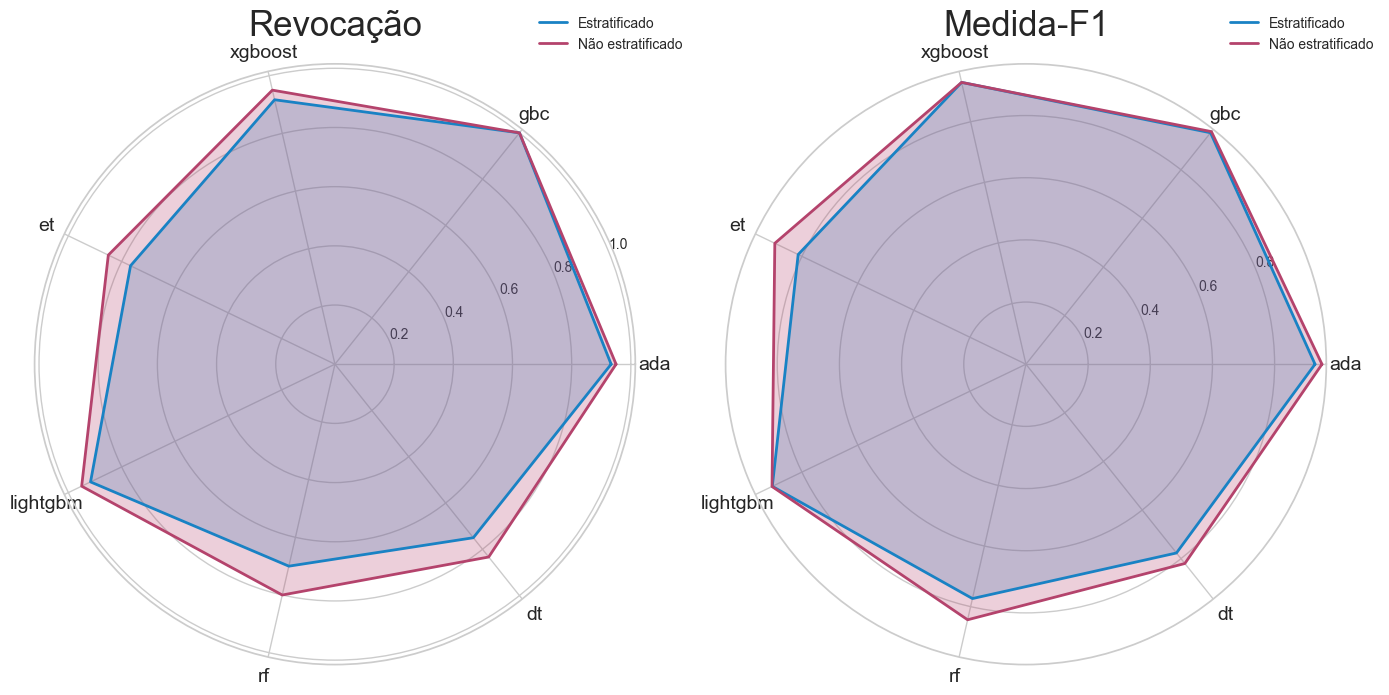

In [88]:
Data_Stratify = {
    "Estratificado": models_comparison_data_split,
    "Não estratificado": models_comparison_transformation_feature
}


compare_metrics(Data_Stratify, 'data_stratify')

### 2.9 Fold Strategy

In [89]:
kfold_pre_processing_setup = setup(
    dataset, 
    target = 'Label',
    date_features = ['Timestamp'],
    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
    imputation_type = 'iterative',
    numeric_iterative_imputer = 'lightgbm',
    fix_imbalance = True,
    fix_imbalance_method = 'SMOTE',
    transformation = True,
    transformation_method = 'yeo-johnson',
    fold_strategy = 'kfold',
    fold = 10
    )

result = test_and_save_pre_processing_approach('kfold_pre_processing', kfold_pre_processing_setup)
models_comparison_kfold = result[0]
dataset_kfold_pre_processing = result[1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12880
[LightGBM] [Info] Number of data points in the train set: 21935, number of used features: 70
[LightGBM] [Info] Start training from score 264365.475691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12880
[LightGBM] [Info] Number of data points in the train set: 21935, number of used features: 70
[LightGBM] [Info] Start training from score 27470.604555
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [92]:
teste_pre_processing_setup = setup(
    dataset, 
    target = 'Label',
    date_features = ['Timestamp'],
    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
    imputation_type = 'iterative',
    numeric_iterative_imputer = 'lightgbm',
    fix_imbalance = True,
    fix_imbalance_method = 'SMOTE',
    transformation = True,
    transformation_method = 'quantile',
    fold_strategy = 'stratifiedkfold',
    fold = 10
    )

result = test_and_save_pre_processing_approach('teste_pre_processing', teste_pre_processing_setup)
models_comparison_teste = result[0]
dataset_teste_pre_processing = result[1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12894
[LightGBM] [Info] Number of data points in the train set: 21929, number of used features: 70
[LightGBM] [Info] Start training from score 278768.462131
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12894
[LightGBM] [Info] Number of data points in the train set: 21929, number of used features: 70
[LightGBM] [Info] Start training from score 27904.435147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

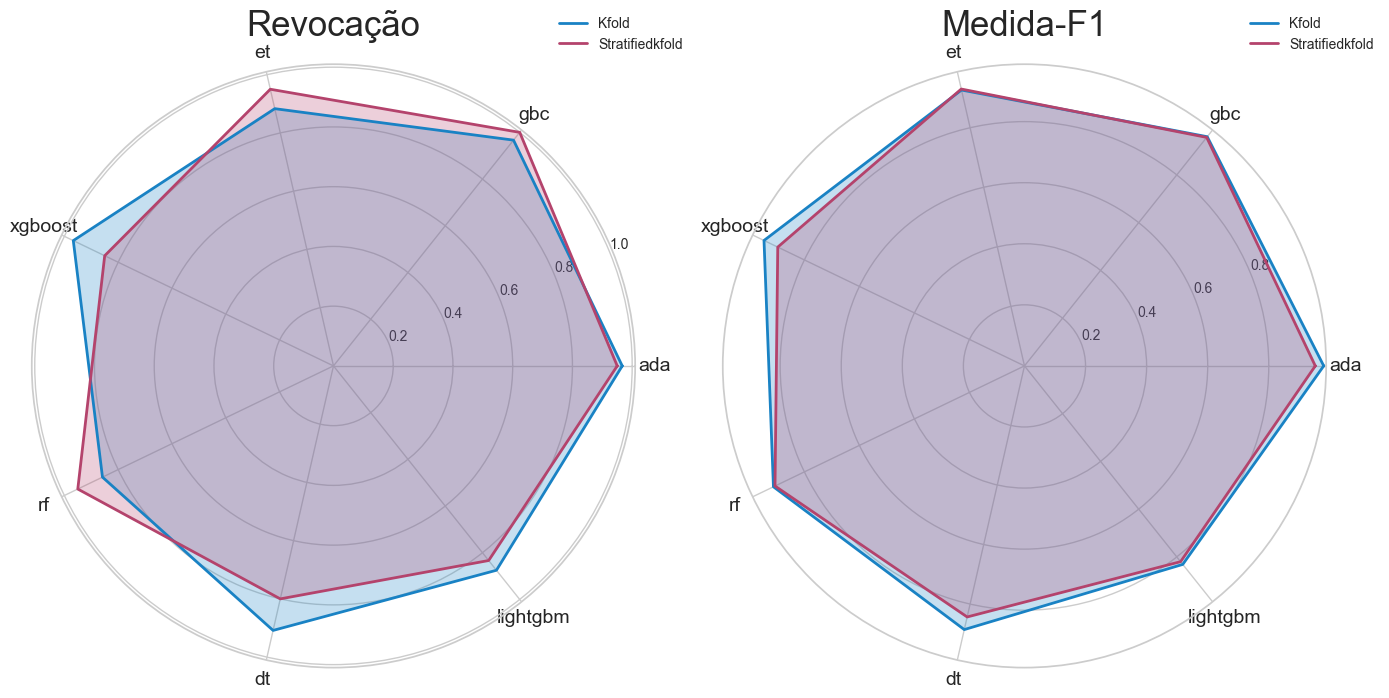

In [91]:
Fold_Strategy = {
    "Kfold": models_comparison_kfold,
    "Stratifiedkfold": models_comparison_transformation_feature
}


compare_metrics(Fold_Strategy, 'fold_strategy')

## Final Pre Processing

In [ ]:
setup_pre_processing_A = setup(
    dataset, 
    target = 'Label',
    date_features = ['Timestamp'],
    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
    imputation_type = 'iterative',
    numeric_iterative_imputer = 'lightgbm',
    fix_imbalance = True,
    fix_imbalance_method = 'SMOTE',
    transformation = True,
    transformation_method = 'yeo-johnson',
    fold_strategy = 'kfold',
    fold = 10
    )

result = test_and_save_pre_processing_approach('A_pre_processing', setup_pre_processing_A)
models_comparison_A = result[0]
pre_processed_dataset_A = result[1]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12895
[LightGBM] [Info] Number of data points in the train set: 21928, number of used features: 70
[LightGBM] [Info] Start training from score 308123.266535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12895
[LightGBM] [Info] Number of data points in the train set: 21928, number of used features: 70
[LightGBM] [Info] Start training from score 29199.721534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

KeyboardInterrupt: 

In [ ]:
setup_pre_processing_B = setup(
    dataset, 
    target = 'Label',
    date_features = ['Timestamp'],
    create_date_columns = ['hour', 'minute', 'second', 'day', 'month'],
    imputation_type = 'iterative',
    numeric_iterative_imputer = 'lightgbm',
    fix_imbalance = True,
    fix_imbalance_method = 'SMOTE',
    transformation = True,
    transformation_method = 'quantile',
    fold_strategy = 'stratifiedkfold',
    fold = 10
    )

result = test_and_save_pre_processing_approach('B_pre_processing', setup_pre_processing_B)
models_comparison_B = result[0]
pre_processed_dataset_B = result[1]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12888
[LightGBM] [Info] Number of data points in the train set: 21931, number of used features: 70
[LightGBM] [Info] Start training from score 320577.543489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12888
[LightGBM] [Info] Number of data points in the train set: 21931, number of used features: 70
[LightGBM] [Info] Start training from score 28418.325932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

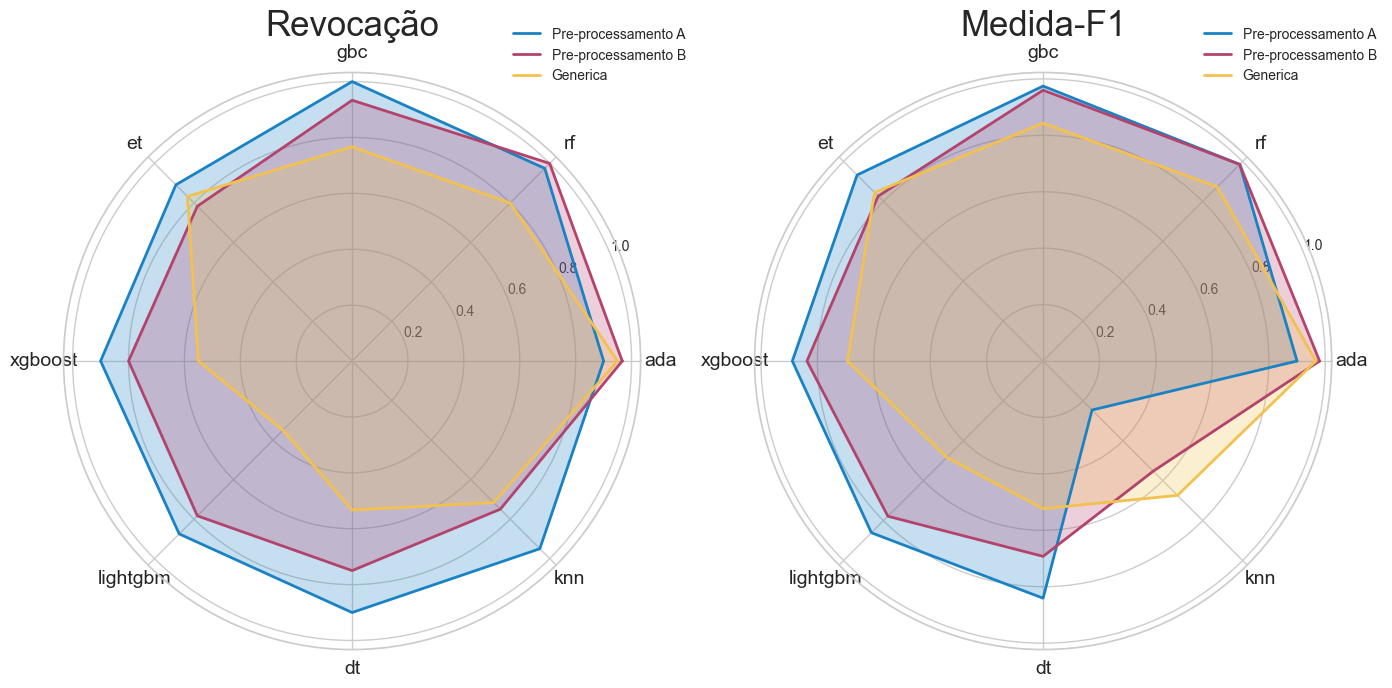

In [ ]:
Teste_Final = {
    "Pre-processamento A": models_comparison_A,
    "Pre-processamento B": models_comparison_B,
    "Generica": models_comparison_generic
}


compare_metrics(Teste_Final, 'teste-final')

In [95]:
save_pre_processed_dataset(pre_processed_dataset_A, "pre_processed_dataset_A")
save_pre_processed_dataset(pre_processed_dataset_B, "pre_processed_dataset_B")